# Simulated Annealing and Random Search

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
import random

In [2]:
class ReadParameters(object):
    def __init__(self):

        # Time Horizon (L - array size)
        self.time_horizon = 120
        # Consumption
        # Talep
        self.consumption = pd.read_csv("miris_load_hour_120_1.csv")
        self.consumption = list(self.consumption['Conso'])
        # Solar Generation
        # Güneş Enerjisi
        self.generation_solar = pd.read_csv("miris_PV_hour_120_1.csv")
        self.generation_solar = list(self.generation_solar['PV'])
        # Initial Load (L)
        self.initial_load = 0

        # Battery Technical Characteristics
        self.battery_capacity_max = 130000
        self.battery_capacity_min = 0
        self.round_trip_efficiency = 0.9
        self.battery_replacement_cost = 100
        self.battery_lifetime_throughput = 647400

        # Unit battery cost
        self.unit_battery_cost = 1000

        # Price
        self.price_purchase = 1000
        self.price_sell = 1000

In [3]:
def CalculateFitness(l_array):

    param = ReadParameters()

    b = np.max(l_array)
    charge = []
    discharge = []
    sell = []
    purchase = []

    for i in range(param.time_horizon):
        # Charge and Discharge
        if i == 0:
            if param.initial_load < l_array[0]:
                charge.append(l_array[0])
                discharge.append(0)
            else:
                charge.append(0)
                discharge.append(0)
        else:
            if l_array[i-1] <= l_array[i]:
                charge.append(l_array[i] - l_array[i-1])
                discharge.append(0)
            else:
                charge.append(0)
                discharge.append(l_array[i-1] - l_array[i])
        # Sell & Purchase
        need = param.consumption[i] + charge[i] - param.generation_solar[i] - discharge[i]
        if need <= 0:
            sell.append(-1 * need)
        else:
            purchase.append(need)

    obj = 0
    # Calculate Objective
    b_cost = param.battery_replacement_cost / (param.battery_lifetime_throughput *
                                                 math.sqrt(param.round_trip_efficiency))
    obj += param.unit_battery_cost * b
    obj += b_cost * np.sum(charge)
    obj += param.price_sell * np.sum(sell)
    obj += param.price_purchase * np.sum(purchase)

    return obj/1000000

In [4]:
def generate_random_array():
    
    max_consumption = max(ReadParameters().consumption)
    max_generation_solar = max(ReadParameters().generation_solar)
    
    upper_limit = max(max_consumption, max_generation_solar)
    lower_limit = 0 
    
    random_array = np.random.randint(lower_limit, upper_limit,  size = ReadParameters().time_horizon)
    
    return random_array

In [5]:
def plot_cost_iteration(data, x_axis, y_axis):
    plt.figure(figsize=(7,7))
    plt.scatter(data[x_axis], data[y_axis])
    plt.title('Cost Function', fontsize=14)
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Cost', fontsize=14)
    plt.xticks(np.arange(0, len(data[x_axis])+1, 200))
    plt.yticks(np.arange(min(data[y_axis]), max(data[y_axis]+0.03), 1))
    plt.show()

## Simulated Annealing

In [6]:
def solutions_neighborhood(solution, neighborhood_size, selection_percentage, modify_rate):
    
    neighborhood_solution = solution.copy()
    selection_size = round(len(neighborhood_solution) * (selection_percentage / 100))
    selection_array = np.random.randint(0, len(neighborhood_solution),  size=selection_size)
    neighborhood_solutions = []
    for j in range(neighborhood_size):
        for i in range(selection_size):
            if random.getrandbits(1):
                neighborhood_solution[selection_array[i]] *= 1 + modify_rate
                neighborhood_solution[selection_array[i]] = min(neighborhood_solution[selection_array[i]], 456)
            else:
                neighborhood_solution[selection_array[i]] *= 1 - modify_rate
                neighborhood_solution[selection_array[i]] = max(0,neighborhood_solution[selection_array[i]] )
        neighborhood_solutions.append(neighborhood_solution)
    return neighborhood_solutions

In [7]:
def function_simulated_annealing(solution_initial, neighborhood_size, temperature, alpha, iteration_max, n_rep, selection_percentage, modify_rate):
    init_temperature = temperature
    init_alpha = alpha
    init_iteration_max = iteration_max
    init_n_rep = n_rep
    init_selection_percentage = selection_percentage
    init_modify_rate = modify_rate
    init_neighborhood_size =  neighborhood_size 
    time_start = time()
    
    iteration_count = 0
    iteration_results = []
    
    solution_current = solution_initial
    
    cost_counter = 0
    cost_min = CalculateFitness(solution_current)
    accepted_move_counter = 0
    rejected_move_counter = 0
    
    while cost_counter < iteration_max:
        
        for i in range(n_rep): 
            solution_temporary = random.choice(solutions_neighborhood(solution_current,neighborhood_size, selection_percentage, modify_rate))
            
            objective_temporary = CalculateFitness(solution_temporary)
            objective_current = CalculateFitness(solution_current)
            objective_delta = objective_temporary - objective_current 
            
            iteration_results.append([iteration_count, objective_current, temperature])                       
            
            if objective_delta < 0:
                solution_current = solution_temporary
            elif np.random.uniform(0, 1) < math.exp(- objective_delta / temperature):
                solution_current = solution_temporary
                accepted_move_counter += 1
            else:
                rejected_move_counter += 1
            if round(objective_current, 2) < round(cost_min, 2):
                cost_min = objective_current
                cost_counter = 0
            elif round(objective_current, 2) == round(cost_min, 2) :
                cost_counter += 1
            
            iteration_count += 1   
            
        temperature *= alpha

    time_end = time()
    time_total = time_end - time_start            
    
    return (iteration_count, objective_current, time_total, init_neighborhood_size, init_temperature, init_alpha, init_modify_rate, init_selection_percentage, init_iteration_max, init_n_rep), iteration_results
    

In [8]:
def print_runs(results):
    # print
    header = ['iteration', 'cost', 'run_time', 'initial_neighborhood_size', 'initial_temperature', 'alpha', 'modify_rate', 'selection_percentages', 'max_iteration', 'n_rep']
    merged_solution_set = np.vstack((header, results))
    data = pd.DataFrame(merged_solution_set)
    new_header = data.iloc[0] 
    data = data[1:] 
    data.columns = new_header
    data["cost"] = data.cost.astype('float64')

    return data

In [9]:
def to_dataframe(results_iterations):
    
    # print
    header = ['iteration', 'cost', 'temperature']
    merged_solution_set = np.vstack((header, results_iterations))
    data = pd.DataFrame(merged_solution_set)
    new_header = data.iloc[0] 
    data = data[1:] 
    data.columns = new_header
    data["cost"] = data.cost.astype('float64')
    
    return data

In [16]:
# parameters
temperature = 10
alpha = 0.9
iteration_max = 20
n_rep = 10
selection_percentage= 0.8
modify_rate = 0.5
neighborhood_size = 20

In [17]:
results = []
results_iterations = []

for i in range(10):
    solution_initial = generate_random_array()

    result, iterations = function_simulated_annealing(solution_initial, neighborhood_size,
                                                      temperature, alpha, iteration_max, n_rep,
                                                      selection_percentage, modify_rate)

    results.append(result)
    results_iterations.append(iterations)
    
data = print_runs(results)
 

In [18]:
data

,iteration,cost,run_time,initial_neighborhood_size,initial_temperature,alpha,modify_rate,selection_percentages,max_iteration,n_rep
1,300.0,12.025381,3.5045111179351807,20.0,10.0,0.9,0.5,0.8,20.0,10.0
2,410.0,11.206389,4.673465013504028,20.0,10.0,0.9,0.5,0.8,20.0,10.0
3,420.0,10.840563,4.905128717422485,20.0,10.0,0.9,0.5,0.8,20.0,10.0
4,370.0,10.328648,4.474050283432007,20.0,10.0,0.9,0.5,0.8,20.0,10.0
5,400.0,12.243990,4.714711427688599,20.0,10.0,0.9,0.5,0.8,20.0,10.0
6,310.0,13.003827,3.754578113555908,20.0,10.0,0.9,0.5,0.8,20.0,10.0
7,480.0,10.968629,5.898606300354004,20.0,10.0,0.9,0.5,0.8,20.0,10.0
8,320.0,11.664778,4.071201324462891,20.0,10.0,0.9,0.5,0.8,20.0,10.0
9,420.0,11.547978,5.610934019088745,20.0,10.0,0.9,0.5,0.8,20.0,10.0
10,360.0,12.626000,4.29018497467041,20.0,10.0,0.9,0.5,0.8,20.0,10.0


In [13]:
data = data['run_time'].astype('float64')

In [14]:
data

1    8.364699
2    6.277217
3    7.567091
4    8.874825
5    8.027409
6    9.154628
Name: run_time, dtype: float64

In [15]:
data.describe()

count    6.000000
mean     8.044311
std      1.036904
min      6.277217
25%      7.682171
50%      8.196054
75%      8.747293
max      9.154628
Name: run_time, dtype: float64

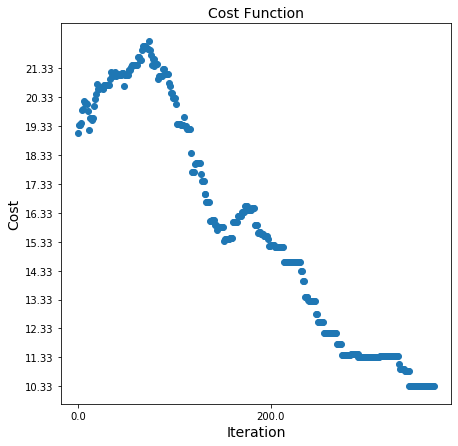

In [19]:
min_cost = 99999999
min_index = 0

for i in range(len(results)):
    if results[i][1] < min_cost:
        min_index = i
        min_cost = results[i][1]
        
plot_cost_iteration(to_dataframe(results_iterations[min_index]), 'iteration', 'cost')

In [20]:
data.to_excel("10runs_120_1.xlsx")

In [17]:
def factorial_design():    
    results = []

    initial_temperatures = [10, 20]
    alpha = [0.8, 0.9]
    modify_rates = [0.5, 0.8]
    selection_percentages = [0.5, 0.8]
    iteration_max = [10, 20]
    n_rep = [5, 10]
    neighborhood_size = [10, 20]
    for a in range(len(initial_temperatures)):
        for b in range( len(alpha)):
            for c in range( len(modify_rates)):
                for d in range( len(selection_percentages)):
                    for e in range(len(iteration_max)):
                        for f in range(len(neighborhood_size)):
                            for g in range( len(n_rep)):
                                for h in range(3):
                                    solution_initial = generate_random_array()

                                    result, iterations = function_simulated_annealing(solution_initial, neighborhood_size[f],
                                                                  initial_temperatures[a], alpha[b], iteration_max[e], n_rep[g],
                                                                  selection_percentages[d], modify_rates[c])

                                    results.append(result)
    return print_runs(results)                        

In [18]:
data = factorial_design()


In [19]:
data

,iteration,cost,run_time,initial_neighborhood_size,initial_temperature,alpha,modify_rate,selection_percentages,max_iteration,n_rep
1,170.0,16.716993,2.124396324157715,10.0,10.0,0.8,0.5,0.5,10.0,5.0
2,210.0,17.553372,2.4747002124786377,10.0,10.0,0.8,0.5,0.5,10.0,5.0
3,180.0,17.075163,2.3197062015533447,10.0,10.0,0.8,0.5,0.5,10.0,5.0
4,280.0,13.942422,3.130629301071167,10.0,10.0,0.8,0.5,0.5,10.0,10.0
5,290.0,14.828590,3.515899658203125,10.0,10.0,0.8,0.5,0.5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...
380,220.0,14.861833,2.690307140350342,20.0,20.0,0.9,0.8,0.8,20.0,5.0
381,265.0,13.307525,3.2200043201446533,20.0,20.0,0.9,0.8,0.8,20.0,5.0
382,270.0,12.807976,3.289274215698242,20.0,20.0,0.9,0.8,0.8,20.0,10.0
383,340.0,13.447732,4.132917881011963,20.0,20.0,0.9,0.8,0.8,20.0,10.0


In [21]:
data.to_excel("results_for_120_1.xlsx")  

## Random Search

In [30]:
def random_search(n):
    #Generate 'n' Random Feasible Solution 
    t0 = time()
    max_consumption = max(ReadParameters().consumption)
    max_generation_solar = max(ReadParameters().generation_solar)
    
    upper_limit = max(max_consumption, max_generation_solar)
    lower_limit = 0 
    
    random_feasible_solutions = np.random.randint(lower_limit, upper_limit,  size=(n, ReadParameters().time_horizon))
    
    #Calculate Objective Function Value of Eah of them and select the best one (minimum)
    objective_value = []
    for i in random_feasible_solutions:
        objective_value.append(CalculateFitness(i))
    t1 = time()
    return min(objective_value), t1-t0

In [31]:
run_results = []
for i in range(10):
    run_results.append(random_search(50000))

In [32]:
run_results

[(15.216783229795512, 288.31032061576843),
 (14.925892139270237, 275.3972556591034),
 (15.236048540420848, 275.142032623291),
 (14.625421062597681, 270.47430205345154),
 (14.790561639282796, 275.90222096443176),
 (14.572921829955929, 275.06361174583435),
 (15.319998294053628, 275.0368959903717),
 (15.346219919920106, 275.5377609729767),
 (15.02907726366368, 276.249263048172),
 (14.858933815772374, 276.9719853401184)]

In [33]:
data1 = pd.DataFrame(run_results)
data1.to_excel("rs_120_1_2.xlsx")